In [1]:
%pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/cs4248")

In [4]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import json
import re
import torch
from torch import nn
from collections import defaultdict
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from sentence_transformers.evaluation import TripletEvaluator
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

In [5]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Device: mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device: cuda")
else:
    device = torch.device('cpu')
    print("Device: cpu")

Device: cuda


In [6]:
file_path_train = 'scicite/train.jsonl'
file_path_dev = 'scicite/dev.jsonl'
file_path_test = 'scicite/test.jsonl'
train_data = []
dev_data = []
test_data = []
with open(file_path_train, 'r', encoding='utf-8') as file:
    for line in file:
        train_data.append(json.loads(line))
with open(file_path_dev, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data.append(json.loads(line))
with open(file_path_test, 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(json.loads(line))
print("Sample data points:")
print(train_data[0])
print(train_data[1])
print(train_data[2])
print("Keys:", list(train_data[0].keys()))
print("Number of training data points:", len(train_data))
print("Label distribution:", {x['label']: sum([1 for y in train_data if y['label'] == x['label']]) for x in train_data[:100]})

Sample data points:
{'source': 'explicit', 'citeEnd': 175, 'sectionName': 'Introduction', 'citeStart': 168, 'string': 'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).', 'label': 'background', 'label_confidence': 1.0, 'citingPaperId': '1872080baa7d30ec8fb87be9a65358cd3a7fb649', 'citedPaperId': '894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'isKeyCitation': True, 'id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'unique_id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11', 'excerpt_index': 11}
{'source': 'explicit', 'citeStart': 16, 'sectionName': 'Novel Quantitative Trait Loci for Seminal Root Traits in Barley', 'string': 'In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological\nrobinson et al.

In [7]:
for data_point in train_data[:10]:
    print("Citation Text:", data_point['string'])
    print("Label:", data_point['label'])
    print("Label Confidence:", data_point['label_confidence'])

Citation Text: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
Label: background
Label Confidence: 1.0
Citation Text: In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological
robinson et al.: genomic regions influencing root traits in barley 11 of 13
maturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.
Label: background
Label Confidence: 1.0
Citation Text: The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Label: background
Label Confidence: 

In [8]:
file_path_train_acl = 'acl-arc/train.jsonl'
file_path_dev_acl = 'acl-arc/dev.jsonl'
file_path_test_acl = 'acl-arc/test.jsonl'
train_data_acl = []
dev_data_acl = []
test_data_acl = []
with open(file_path_train_acl, 'r', encoding='utf-8') as file:
    for line in file:
        train_data_acl.append(json.loads(line))
with open(file_path_dev_acl, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data_acl.append(json.loads(line))
with open(file_path_test_acl, 'r', encoding='utf-8') as file:
    for line in file:
        test_data_acl.append(json.loads(line))
print("Sample data points:")
print(train_data_acl[0])
print(train_data_acl[1])
print(train_data_acl[2])
print("Keys:", list(train_data_acl[0].keys()))
print("Number of training data points:", len(train_data_acl))
print("Label distribution:", {x['intent']: sum([1 for y in train_data_acl if y['intent'] == x['intent']]) for x in train_data_acl[:100]})

Sample data points:
{'text': 'Thus , over the past few years , along with advances in the use of learning and statistical methods for acquisition of full parsers ( Collins , 1997 ; Charniak , 1997a ; Charniak , 1997b ; Ratnaparkhi , 1997 ) , significant progress has been made on the use of statistical learning methods to recognize shallow parsing patterns syntactic phrases or words that participate in a syntactic relationship ( Church , 1988 ; Ramshaw and Marcus , 1995 ; Argamon et al. , 1998 ; Cardie and Pierce , 1998 ; Munoz et al. , 1999 ; Punyakanok and Roth , 2001 ; Buchholz et al. , 1999 ; Tjong Kim Sang and Buchholz , 2000 ) .', 'citing_paper_id': 'W01-0706', 'cited_paper_id': 'External_555', 'citing_paper_year': 2001, 'cited_paper_year': 1997, 'citing_paper_title': 'a holistic lexiconbased approach to opinion mining', 'cited_paper_title': 'three generative lexicalised models for statistical parsing', 'cited_author_ids': ['M Collins'], 'citing_author_ids': None, 'extended_contex

In [10]:
len(train_data), len(dev_data), len(test_data)

(8243, 916, 1861)

In [11]:
for data in train_data_acl:
    label = ''
    if data['intent'] == 'Background':
        label = 'background'
    elif data['intent'] == 'Uses':
        label = 'method'
    elif data['intent'] == 'CompareOrContrast':
        label = 'result'
    else:
        continue
    d = {'string': data['text'], 'label': label}
    train_data.append(d)

for data in dev_data_acl:
    label = ''
    if data['intent'] == 'Background':
        label = 'background'
    elif data['intent'] == 'Uses':
        label = 'method'
    elif data['intent'] == 'CompareOrContrast':
        label = 'result'
    else:
        continue
    section_name = ''
    if data['section_name'] != None:
        section_name = data['section_name']
    d = {'string': data['text'], 'sectionName': section_name, 'label': label}
    dev_data.append(d)

for data in test_data_acl:
    label = ''
    if data['intent'] == 'Background':
        label = 'background'
    elif data['intent'] == 'Uses':
        label = 'method'
    elif data['intent'] == 'CompareOrContrast':
        label = 'result'
    else:
        continue
    d = {'string': data['text'], 'label': label}
    test_data.append(d)

In [12]:
len(train_data), len(dev_data), len(test_data)

(9732, 1017, 1983)

In [13]:
# Use SciBERT for mapping text to embeddings
model_name = 'allenai/scibert_scivocab_uncased'
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [14]:
section_names = list(set(d['sectionName'] for d in dev_data))

In [15]:
def clean_section_name(section_name):
    pattern_1 = r'^\d+(\.\d+)*\.*\s*'
    pattern_2 = r'^\w+\.(\w+\.)*\.*\s'

    section_name = section_name.lower() # Lower-case folding
    cleaned_section_name = re.sub(pattern_1, '', section_name) # Remove section numbers (e.g. "2.", "1.2")
    cleaned_section_name = re.sub(pattern_2, '', cleaned_section_name) #Remove section letters (e.g. "A.", "II.")
    cleaned_section_name = re.sub('[^a-zA-Z0-9\s]', '', cleaned_section_name) # Remove special characters
    return cleaned_section_name

def preprocess_section_names(section_names):
    res = []
    for section_name in section_names:
        cleaned_section_name = clean_section_name(section_name)
        res.append(cleaned_section_name)
    return res

In [16]:
def compute_cossim(section_names):
    section_embeddings = model.encode(cleaned_section_names)
    section_embeddings = torch.tensor(section_embeddings)

    # Compute cosine similarity between section names
    cos_sim = nn.functional.cosine_similarity(section_embeddings.unsqueeze(1), section_embeddings.unsqueeze(0), dim=-1)
    print(f'Shape of cossim: {cos_sim.shape}')
    return cos_sim

cleaned_section_names = preprocess_section_names(section_names)
cleaned_section_names = list(set(cleaned_section_names))
cossim_matrix = compute_cossim(cleaned_section_names)

Shape of cossim: torch.Size([150, 150])


In [17]:
def get_most_and_least_similar_sections(cos_sim):
    most_similar_sections = []
    least_similar_sections = []
    for i in range(len(cleaned_section_names)):
        # Exclude self-similarity by setting diagonal elements to negative inf
        cos_sim[i][i] = float("-inf")

        # Find index of section with the highest cosine similarity (most similar)
        most_similar_idx = torch.argmax(cos_sim[i]).item()
        most_similar_sections.append(cleaned_section_names[most_similar_idx])

        # Exclude self-similarity by setting diagonal elements to positive inf
        cos_sim[i][i] = float("inf")
        # Find index of section with the lowest cosine similarity (least similar)
        least_similar_idx = torch.argmin(cos_sim[i]).item()
        least_similar_sections.append(cleaned_section_names[least_similar_idx])

    return most_similar_sections, least_similar_sections

most_similar_sections, least_similar_sections = get_most_and_least_similar_sections(cossim_matrix)

In [18]:
class CitationsDataset:
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return InputExample(guid=item, texts=[self.data[item]['string']], label=CitationsDataset.label_to_id[self.data[item]['label']])

In [19]:
class CitationsDataset_with_section_name:
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return InputExample(guid=item, texts=[self.data[item]['string'], self.data[item]['sectionName']], label=CitationsDataset.label_to_id[self.data[item]['label']])

In [20]:
# Parameters
train_batch_size = 16
dev_batch_size = train_batch_size
test_batch_size = train_batch_size
num_epochs = 5

In [21]:
train_dataset = CitationsDataset(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [ ]:
# def triplets_from_labeled_dataset(input_examples):
#     # Create triplets for a [(label, sentence), (label, sentence)...] dataset
#     # by using each example as an anchor and selecting randomly a
#     # positive instance with the same label and a negative instance with a different label
#     triplets = []
#     label2sentence = defaultdict(list)
#     for inp_example in input_examples:
#         print(inp_example)
#         label2sentence[inp_example.label].append(inp_example)

#     for inp_example in input_examples:
#         anchor = inp_example

#         if len(label2sentence[inp_example.label]) < 2:  # We need at least 2 examples per label to create a triplet
#             continue

#         positive = None
#         while positive is None or positive.guid == anchor.guid:
#             positive = random.choice(label2sentence[inp_example.label])

#         negative = None
#         while negative is None or negative.label == anchor.label:
#             negative = random.choice(input_examples)

#         triplets.append(InputExample(texts=[anchor.texts[0], positive.texts[0], negative.texts[0]]))

#     return triplets

In [22]:
def triplets_from_labeled_dataset_section_name(input_examples):
    # Create triplets for a [(section_name, sentence), (section_name, sentence)...] dataset
    # by using each example as an anchor and selecting randomly a
    # positive instance with the section name of highest similarity and a negative instance with the section name of lowest similarity
    # when compared to the section name of the anchor
    triplets = []
    section2sentence = defaultdict(list)
    for inp_example in input_examples:
        section2sentence[inp_example.texts[1]].append(inp_example)

    for inp_example in input_examples:
        anchor = inp_example

        section_name_anchor = anchor.texts[1]

        if len(section2sentence[inp_example.texts[1]]) >= 2: # Randomly pick a positive instance (another of same section name)
            positive = None
            while positive is None or positive.guid == anchor.guid:
                positive = random.choice(section2sentence[inp_example.texts[1]])
        else: # Anchor's section name is unique, so pick a positive instance with section name of highest similarity
            most_similar_section = most_similar_sections[cleaned_section_names.index(section_name_anchor)]
            positive = random.choice(section2sentence[most_similar_section])

        least_similar_section = least_similar_sections[cleaned_section_names.index(section_name_anchor)]

        negative = random.choice(section2sentence[least_similar_section])

        triplets.append(InputExample(texts=[anchor.texts[0], positive.texts[0], negative.texts[0]]))

    return triplets

In [23]:
for data in dev_data:
    data['sectionName'] = clean_section_name(data['sectionName'])

In [24]:
dev_dataset = CitationsDataset_with_section_name(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)
dev_triplets = triplets_from_labeled_dataset_section_name(dev_dataset)

In [25]:
print(len(dev_triplets), len(dev_dataset))
print(dev_triplets[0].texts)

1017 1017
['These results are in contrast with the findings of Santos et al.(16), who reported a significant association between low sedentary time and healthy CVF among Portuguese', 'This study and results provided in Holland et al. (2013, 2014a), suggest that the presence of HA has a positive effect on aquatic organisms and may aid their survival to multiple stressors such as low pH and heavy metal mixtures associated with AMD.', '…by offering a consistent way to differentiate two types of results that provide evidence of statistical mediation, drawing on earlier work (Baron & Kenny, 1986) and more recent advances in meditational modeling (Hayes, 2013; MacKinnon et al., 2007; Preacher, 2015; Preacher & Hayes, 2004).']


In [26]:
train_loss = losses.BatchAllTripletLoss(model=model)
dev_evaluator = TripletEvaluator.from_input_examples(dev_triplets, name="scibert-dev-triplets")
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

In [27]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path='output/pre_trained_scibert-sciciteplusacl-section-name'
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/609 [00:00<?, ?it/s]

Iteration:   0%|          | 0/609 [00:00<?, ?it/s]

Iteration:   0%|          | 0/609 [00:00<?, ?it/s]

Iteration:   0%|          | 0/609 [00:00<?, ?it/s]

Iteration:   0%|          | 0/609 [00:00<?, ?it/s]

In [28]:
# Sanity check pretraining results
model = SentenceTransformer('output/pre_trained_scibert-sciciteplusacl-section-name')

sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of strings.",
    "The quick brown fox jumps over the lazy dog.",
]

embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [ 1.75741434e-01 -1.17892015e+00 -1.02574658e+00  7.08758235e-01
  1.03175819e+00 -5.14366746e-01  9.43948478e-02  1.08499881e-02
  5.24894059e-01 -5.67040205e-01  8.54519248e-01  6.96664989e-01
 -7.82571912e-01  4.00071666e-02 -1.22921471e-03 -6.25026882e-01
  5.76356575e-02 -9.04841244e-01  2.44577378e-01  6.09360993e-01
  1.48997948e-01 -4.35785115e-01 -1.12612724e-01 -6.78349614e-01
  8.17830682e-01  8.47576320e-01  1.76048309e-01  2.57594377e-01
 -1.36202562e+00  6.51220262e-01 -3.48709166e-01 -5.25712907e-01
 -8.51414025e-01  3.08012664e-01  7.11007655e-01  4.11626011e-01
  4.16211784e-01 -1.08285344e+00 -1.54034889e+00  3.45106900e-01
 -1.13207936e+00  3.10175776e-01  1.57937038e+00 -5.42785943e-01
  4.18850511e-01  2.99008310e-01  7.24807858e-01 -3.84326518e-01
 -1.05899143e+00 -2.07265615e-01  1.00716853e+00 -6.95913136e-01
 -5.25403142e-01  7.77459025e-01  1.76620871e-01 -6.61289692e-02
  4.28795

In [29]:
# Dimension of each sentence embedding
print(embeddings[0].shape)

(768,)


------------------------
## Visualization of the embedding space using PCA

In [30]:
def perform_pca(train_data):
    embeddings = []
    labels = []
    for data in train_data:
        embedding = model.encode(data['string'])
        embeddings.append(embedding)
        labels.append(data['label'])
    embeddings = np.array(embeddings)
    pca = PCA(n_components=2)
    res_embeddings = pca.fit_transform(embeddings)
    print(str(pca.explained_variance_ratio_.sum() * 100) + "% variance explained using PCA")
    return res_embeddings, labels

def plot(embeddings, labels):
    embeddings = list(embeddings)
    embeddings_x = [emb[0] for emb in embeddings]
    embeddings_y = [emb[1] for emb in embeddings]
    sb.set_style("darkgrid")
    sb.relplot(x=embeddings_x, y=embeddings_y, hue=labels, palette="deep", alpha=0.7, s=75)
    plt.title("Train embeddings")

73.57252836227417% variance explained using PCA


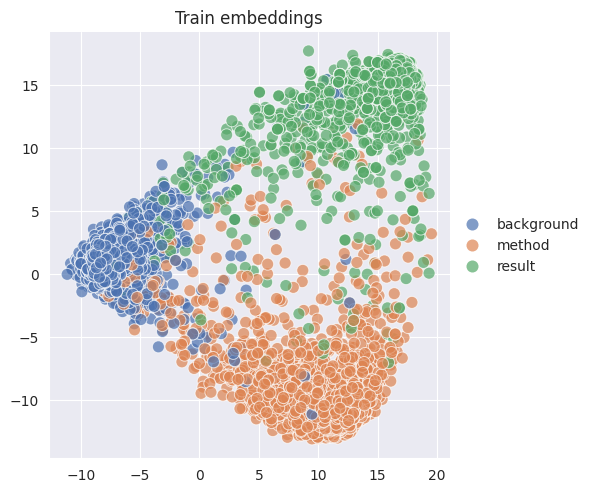

In [31]:
# With contrastive pretraining

res_embeddings, labels = perform_pca(train_data)
plot(res_embeddings, labels)

In [32]:
 # Use SciBERT for mapping text to embeddings
model_name = 'allenai/scibert_scivocab_uncased'
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

13.667522370815277% variance explained using PCA


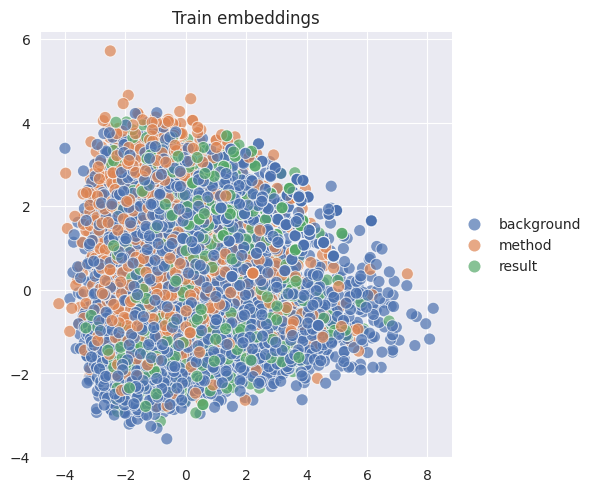

In [33]:
# Without contrastive pretraining

orig_embeddings, labels = perform_pca(train_data)
plot(orig_embeddings, labels)

## End of Visualization
------------------------

In [34]:
class CitationIntentClassifier(nn.Module):
    def __init__(self, model_path, num_labels):
        super(CitationIntentClassifier, self).__init__()
        self.sentence_transformer = SentenceTransformer(model_path)
        self.classifier = nn.Linear(self.sentence_transformer.get_sentence_embedding_dimension(), num_labels)

    def forward(self, input_texts):
        embeddings = self.sentence_transformer.encode(input_texts, convert_to_tensor=True)
        return self.classifier(embeddings)

In [35]:
model_path = 'output/pre_trained_scibert-sciciteplusacl-section-name'
num_labels = len(CitationsDataset.label_to_id)
citation_intent_classifier = CitationIntentClassifier(model_path, num_labels).to(device)

In [36]:
# Parameters
learning_rate = 2e-5
num_epochs = 5

In [37]:
optimizer = torch.optim.Adam(citation_intent_classifier.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

In [38]:
class CitationsDatasetWithoutInputExample():
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]['string'], CitationsDatasetWithoutInputExample.label_to_id[self.data[item]['label']]

In [39]:
train_dataset = CitationsDatasetWithoutInputExample(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [40]:
dev_dataset = CitationsDatasetWithoutInputExample(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

In [41]:
def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for input_texts, labels in dataloader:
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(input_texts)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Training loss: {total_loss / len(dataloader)}")

def evaluate(model, dataloader, loss_func):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
    print(f"Evaluation loss: {total_loss / len(dataloader)}")
    print(f"Evaluation accuracy: {total_correct / len(dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch(citation_intent_classifier, train_dataloader, loss_func, optimizer)
    evaluate(citation_intent_classifier, dev_dataloader, loss_func)

Epoch 1/5
Training loss: 0.5411366950261769
Evaluation loss: 0.47129310038872063
Evaluation accuracy: 0.8475909537856441
Epoch 2/5
Training loss: 0.1766765450658078
Evaluation loss: 0.47320245718583465
Evaluation accuracy: 0.8475909537856441
Epoch 3/5
Training loss: 0.13519173693860007
Evaluation loss: 0.503561434452422
Evaluation accuracy: 0.8475909537856441
Epoch 4/5
Training loss: 0.12365317843817725
Evaluation loss: 0.5282300589606166
Evaluation accuracy: 0.8475909537856441
Epoch 5/5
Training loss: 0.11903124825940245
Evaluation loss: 0.5474794935144018
Evaluation accuracy: 0.8466076696165191


In [42]:
test_dataset = CitationsDatasetWithoutInputExample(test_data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [43]:
def test(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            _, predicted_labels = torch.max(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

predictions, true_labels = test(citation_intent_classifier, test_dataloader, device)

In [44]:
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.8467712230931052
